In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt

In [8]:
model = models.resnet50(pretrained=True) #Using the CNN model resnet50

C:\Users\nabee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nabee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
num_features = model.fc.in_features

model.fc = nn.Linear(num_features, 30)#Used in order to make sure that the model outputs predictions for only 30 counties instead of the number this model used to output.

In [10]:
from sklearn.model_selection import train_test_split

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  #Randomly crop to 224x224
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])   
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),  
])


full_dataset = datasets.ImageFolder(root='./dataset')

#Print the classes detected
print("Classes found:", full_dataset.classes)

np.random.seed(42) 

#The code below insures that each country gets it's fair share of representation while training, preventing bias towards specific countries.

class_indices = {}

for index, sample in enumerate(full_dataset.samples):
    _, label = sample

    if label not in class_indices:
        class_indices[label] = []

    class_indices[label].append(index)

#Checking the number of pictures for each label to be sure
for label in class_indices:
    print(f"Class {full_dataset.classes[label]} has {len(class_indices[label])} images.")

train_indices = []
test_indices = []

for label, image_indices in class_indices.items():
    shuffled_indices = np.array(image_indices)
    np.random.shuffle(shuffled_indices)

    #Split the shuffled indices into training,validation and testing sets
    train_val_split = shuffled_indices[:800]
    test_split = shuffled_indices[800:1000]

    train_indices.extend(train_val_split)
    test_indices.extend(test_split)

#Split train_indices into new_train_indices and val_indices
train_indices_per_class = {}
val_indices_per_class = {}

for label in range(len(full_dataset.classes)):
    indices = []

    
    for index in train_indices:
        #Check if the label of the current sample matches the given label
        if full_dataset.samples[index][1] == label:
            indices.append(index)

    #Split into train and validation (80% train, 20% validation)
    train_index, val_index = train_test_split(indices, test_size=0.2, random_state=42) 
    train_indices_per_class[label] = train_index
    val_indices_per_class[label] = val_index

#Eventually, combine indices from all classes
new_train_indices = []
val_indices = []

for label in range(len(full_dataset.classes)):
    new_train_indices.extend(train_indices_per_class[label])
    val_indices.extend(val_indices_per_class[label])

new_train_subset = Subset(full_dataset, new_train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

#Define a custom Dataset class to apply transforms (Used LLM here)
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset 
        self.transform = transform

    def __getitem__(self, index):
        image_path, label = self.subset.dataset.samples[self.subset.indices[index]]
        image = self.subset.dataset.loader(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

#Wrap the subsets with TransformedDataset to apply transforms
new_train_dataset = TransformedDataset(new_train_subset, transform=train_transform)
val_dataset = TransformedDataset(val_subset, transform=test_transform)
test_dataset = TransformedDataset(test_subset, transform=test_transform)

#Create DataLoaders
train_loader = DataLoader(new_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Classes found: ['AR', 'AT', 'BE', 'BR', 'CA', 'CH', 'CL', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'IE', 'IL', 'IN', 'JP', 'KR', 'MX', 'NL', 'NO', 'NZ', 'PL', 'PT', 'SE', 'TH', 'UK', 'US', 'ZA']
Class AR has 1000 images.
Class AT has 1000 images.
Class BE has 1000 images.
Class BR has 1000 images.
Class CA has 1000 images.
Class CH has 1000 images.
Class CL has 1000 images.
Class CZ has 1000 images.
Class DE has 1000 images.
Class DK has 1000 images.
Class EE has 1000 images.
Class ES has 1000 images.
Class FI has 1000 images.
Class FR has 1000 images.
Class IE has 1000 images.
Class IL has 1000 images.
Class IN has 1000 images.
Class JP has 1000 images.
Class KR has 1000 images.
Class MX has 1000 images.
Class NL has 1000 images.
Class NO has 1000 images.
Class NZ has 1000 images.
Class PL has 1000 images.
Class PT has 1000 images.
Class SE has 1000 images.
Class TH has 1000 images.
Class UK has 1000 images.
Class US has 1000 images.
Class ZA has 1000 images.


In [11]:
from collections import Counter

#Train the model.
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    device = torch.device("cuda")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []  
    val_accuracies = []  
    best_val_accuracy = 0.0  

    for epoch in range(epochs):
        #Set model to training mode
        model.train()
        epoch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch in train_loader:
            
            images, labels = batch
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            #loss and accuracy
            epoch_loss += loss.item()
            total_samples += labels.size(0)
            correct_predictions += (predictions.argmax(dim=1) == labels).sum().item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_accuracy = 100 * correct_predictions / total_samples
        train_accuracies.append(train_accuracy)

        #Validation
        model.eval()  
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  
            for batch in test_loader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)
              
                predictions = model(images)
               
                loss = criterion(predictions, labels)
                val_loss += loss.item()  

                predicted_classes = predictions.argmax(dim=1)
                total_val += labels.size(0)
                correct_val += (predicted_classes == labels).sum().item()

        avg_val_loss = val_loss / len(test_loader)  
        val_losses.append(avg_val_loss)

        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)

        #LLM used to make it look good
        print(f'Epoch [{epoch+1}/{epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.2f}%, '
              f'Validation Accuracy: {val_accuracy:.2f}%')

      
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = model.state_dict().copy()


    model.load_state_dict(best_model_wts)

    #Used LLM for plots
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss', linestyle='-', marker='o', color='blue')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', linestyle='-', marker='x', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)  
    plt.show()

    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', linestyle='-', marker='o', color='blue')
    plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', linestyle='-', marker='x', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True) 
    plt.show()


Epoch [1/25], Train Loss: 3.2917, Validation Loss: 3.1049, Train Accuracy: 8.82%, Validation Accuracy: 17.06%
Epoch [2/25], Train Loss: 3.0897, Validation Loss: 2.9254, Train Accuracy: 16.10%, Validation Accuracy: 20.79%
Epoch [3/25], Train Loss: 2.9697, Validation Loss: 2.8109, Train Accuracy: 19.52%, Validation Accuracy: 22.65%
Epoch [4/25], Train Loss: 2.8886, Validation Loss: 2.7274, Train Accuracy: 21.09%, Validation Accuracy: 24.62%
Epoch [5/25], Train Loss: 2.8337, Validation Loss: 2.6719, Train Accuracy: 21.93%, Validation Accuracy: 25.98%
Epoch [6/25], Train Loss: 2.7805, Validation Loss: 2.6166, Train Accuracy: 23.23%, Validation Accuracy: 27.10%
Epoch [7/25], Train Loss: 2.7449, Validation Loss: 2.6014, Train Accuracy: 23.56%, Validation Accuracy: 26.29%
Epoch [8/25], Train Loss: 2.7150, Validation Loss: 2.5420, Train Accuracy: 24.56%, Validation Accuracy: 28.60%
Epoch [9/25], Train Loss: 2.6912, Validation Loss: 2.5325, Train Accuracy: 25.05%, Validation Accuracy: 28.92%
Ep

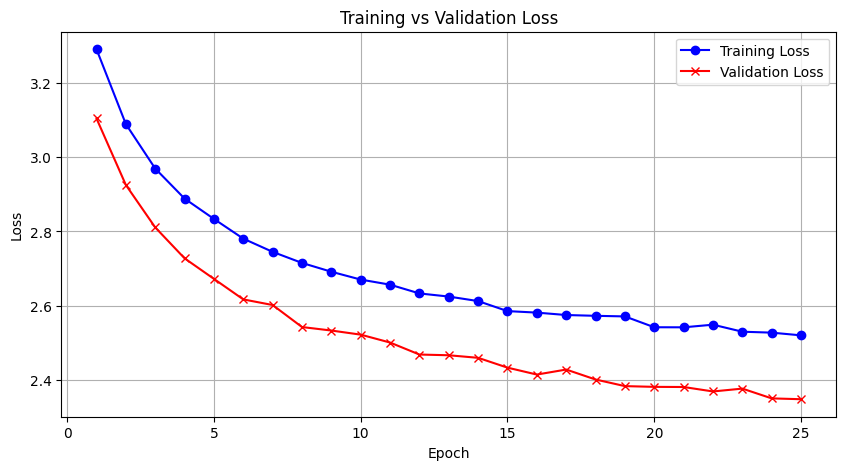

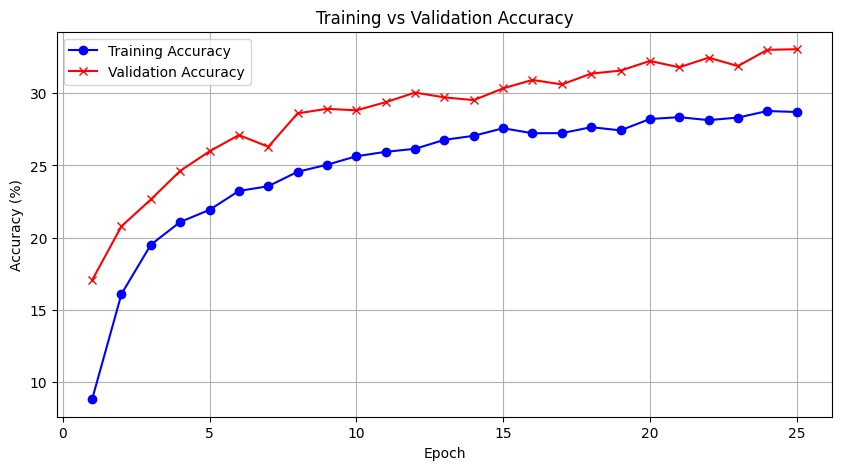

Epoch [1/40], Train Loss: 2.3180, Validation Loss: 1.9541, Train Accuracy: 33.61%, Validation Accuracy: 42.79%
Epoch [2/40], Train Loss: 2.0639, Validation Loss: 1.7682, Train Accuracy: 39.85%, Validation Accuracy: 47.75%
Epoch [3/40], Train Loss: 1.8913, Validation Loss: 1.6091, Train Accuracy: 44.62%, Validation Accuracy: 51.04%
Epoch [4/40], Train Loss: 1.7643, Validation Loss: 1.4944, Train Accuracy: 47.86%, Validation Accuracy: 54.21%
Epoch [5/40], Train Loss: 1.6696, Validation Loss: 1.4216, Train Accuracy: 50.73%, Validation Accuracy: 57.02%
Epoch [6/40], Train Loss: 1.5596, Validation Loss: 1.3691, Train Accuracy: 53.87%, Validation Accuracy: 58.65%
Epoch [7/40], Train Loss: 1.4819, Validation Loss: 1.3030, Train Accuracy: 55.93%, Validation Accuracy: 60.56%
Epoch [8/40], Train Loss: 1.4030, Validation Loss: 1.2381, Train Accuracy: 58.17%, Validation Accuracy: 62.17%
Epoch [9/40], Train Loss: 1.3303, Validation Loss: 1.2164, Train Accuracy: 60.46%, Validation Accuracy: 63.08%
E

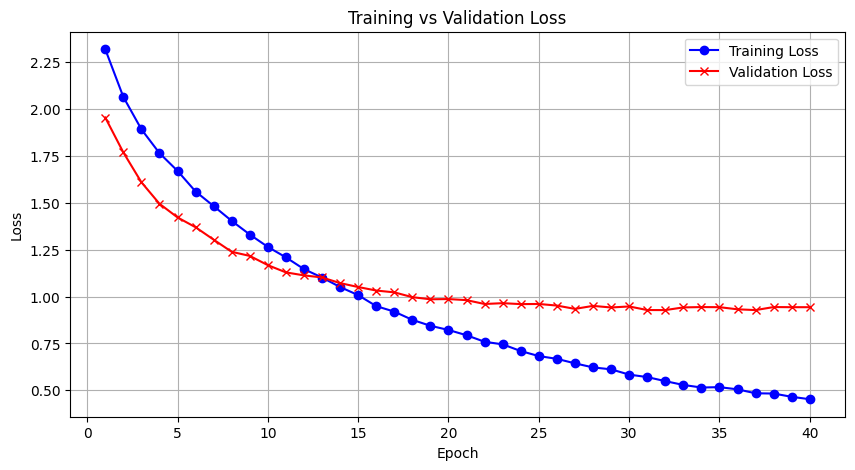

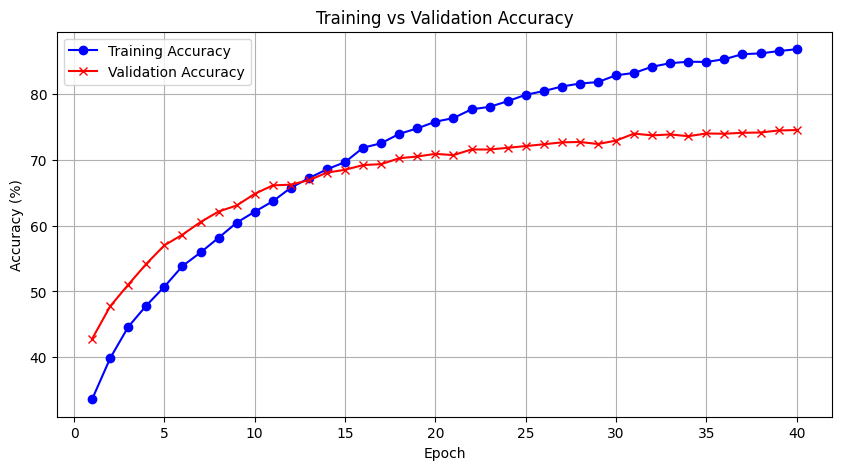

In [12]:
#Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

#Define criterion and optimizer for the initial training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)  

#Train the final layer for few epochs before unfreezing
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25)

#Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

#Define optimizer for fine-tuning
optimizer = optim.Adam(model.parameters(), lr=0.00001)

#Fine-tune the entire model
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40)

In [13]:
def evaluate_model(model, test_loader):
    device = torch.device("cuda")
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    class_correct = [0] * len(full_dataset.classes)
    class_total = [0] * len(full_dataset.classes)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #the _ to ignore the first value returned by max, we only care about the predicted class.

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == labels[i]).item()
                class_total[label] += 1

    overall_accuracy = 100 * correct / total
    print(f'Overall Test Accuracy: {overall_accuracy:.2f}%')
    for i in range(len(full_dataset.classes)):
        print(f'Accuracy of {full_dataset.classes[i]}: '
              f'{100 * class_correct[i] / class_total[i]:.2f}%')
        

        
evaluate_model(model, test_loader)

Overall Test Accuracy: 75.37%
Accuracy of AR: 62.00%
Accuracy of AT: 86.50%
Accuracy of BE: 93.00%
Accuracy of BR: 62.00%
Accuracy of CA: 59.50%
Accuracy of CH: 96.50%
Accuracy of CL: 73.00%
Accuracy of CZ: 86.50%
Accuracy of DE: 77.00%
Accuracy of DK: 93.00%
Accuracy of EE: 93.50%
Accuracy of ES: 61.50%
Accuracy of FI: 73.00%
Accuracy of FR: 50.50%
Accuracy of IE: 94.00%
Accuracy of IL: 98.50%
Accuracy of IN: 97.50%
Accuracy of JP: 68.50%
Accuracy of KR: 78.50%
Accuracy of MX: 46.00%
Accuracy of NL: 95.50%
Accuracy of NO: 67.50%
Accuracy of NZ: 75.50%
Accuracy of PL: 76.50%
Accuracy of PT: 85.50%
Accuracy of SE: 60.50%
Accuracy of TH: 70.00%
Accuracy of UK: 62.00%
Accuracy of US: 39.00%
Accuracy of ZA: 78.50%


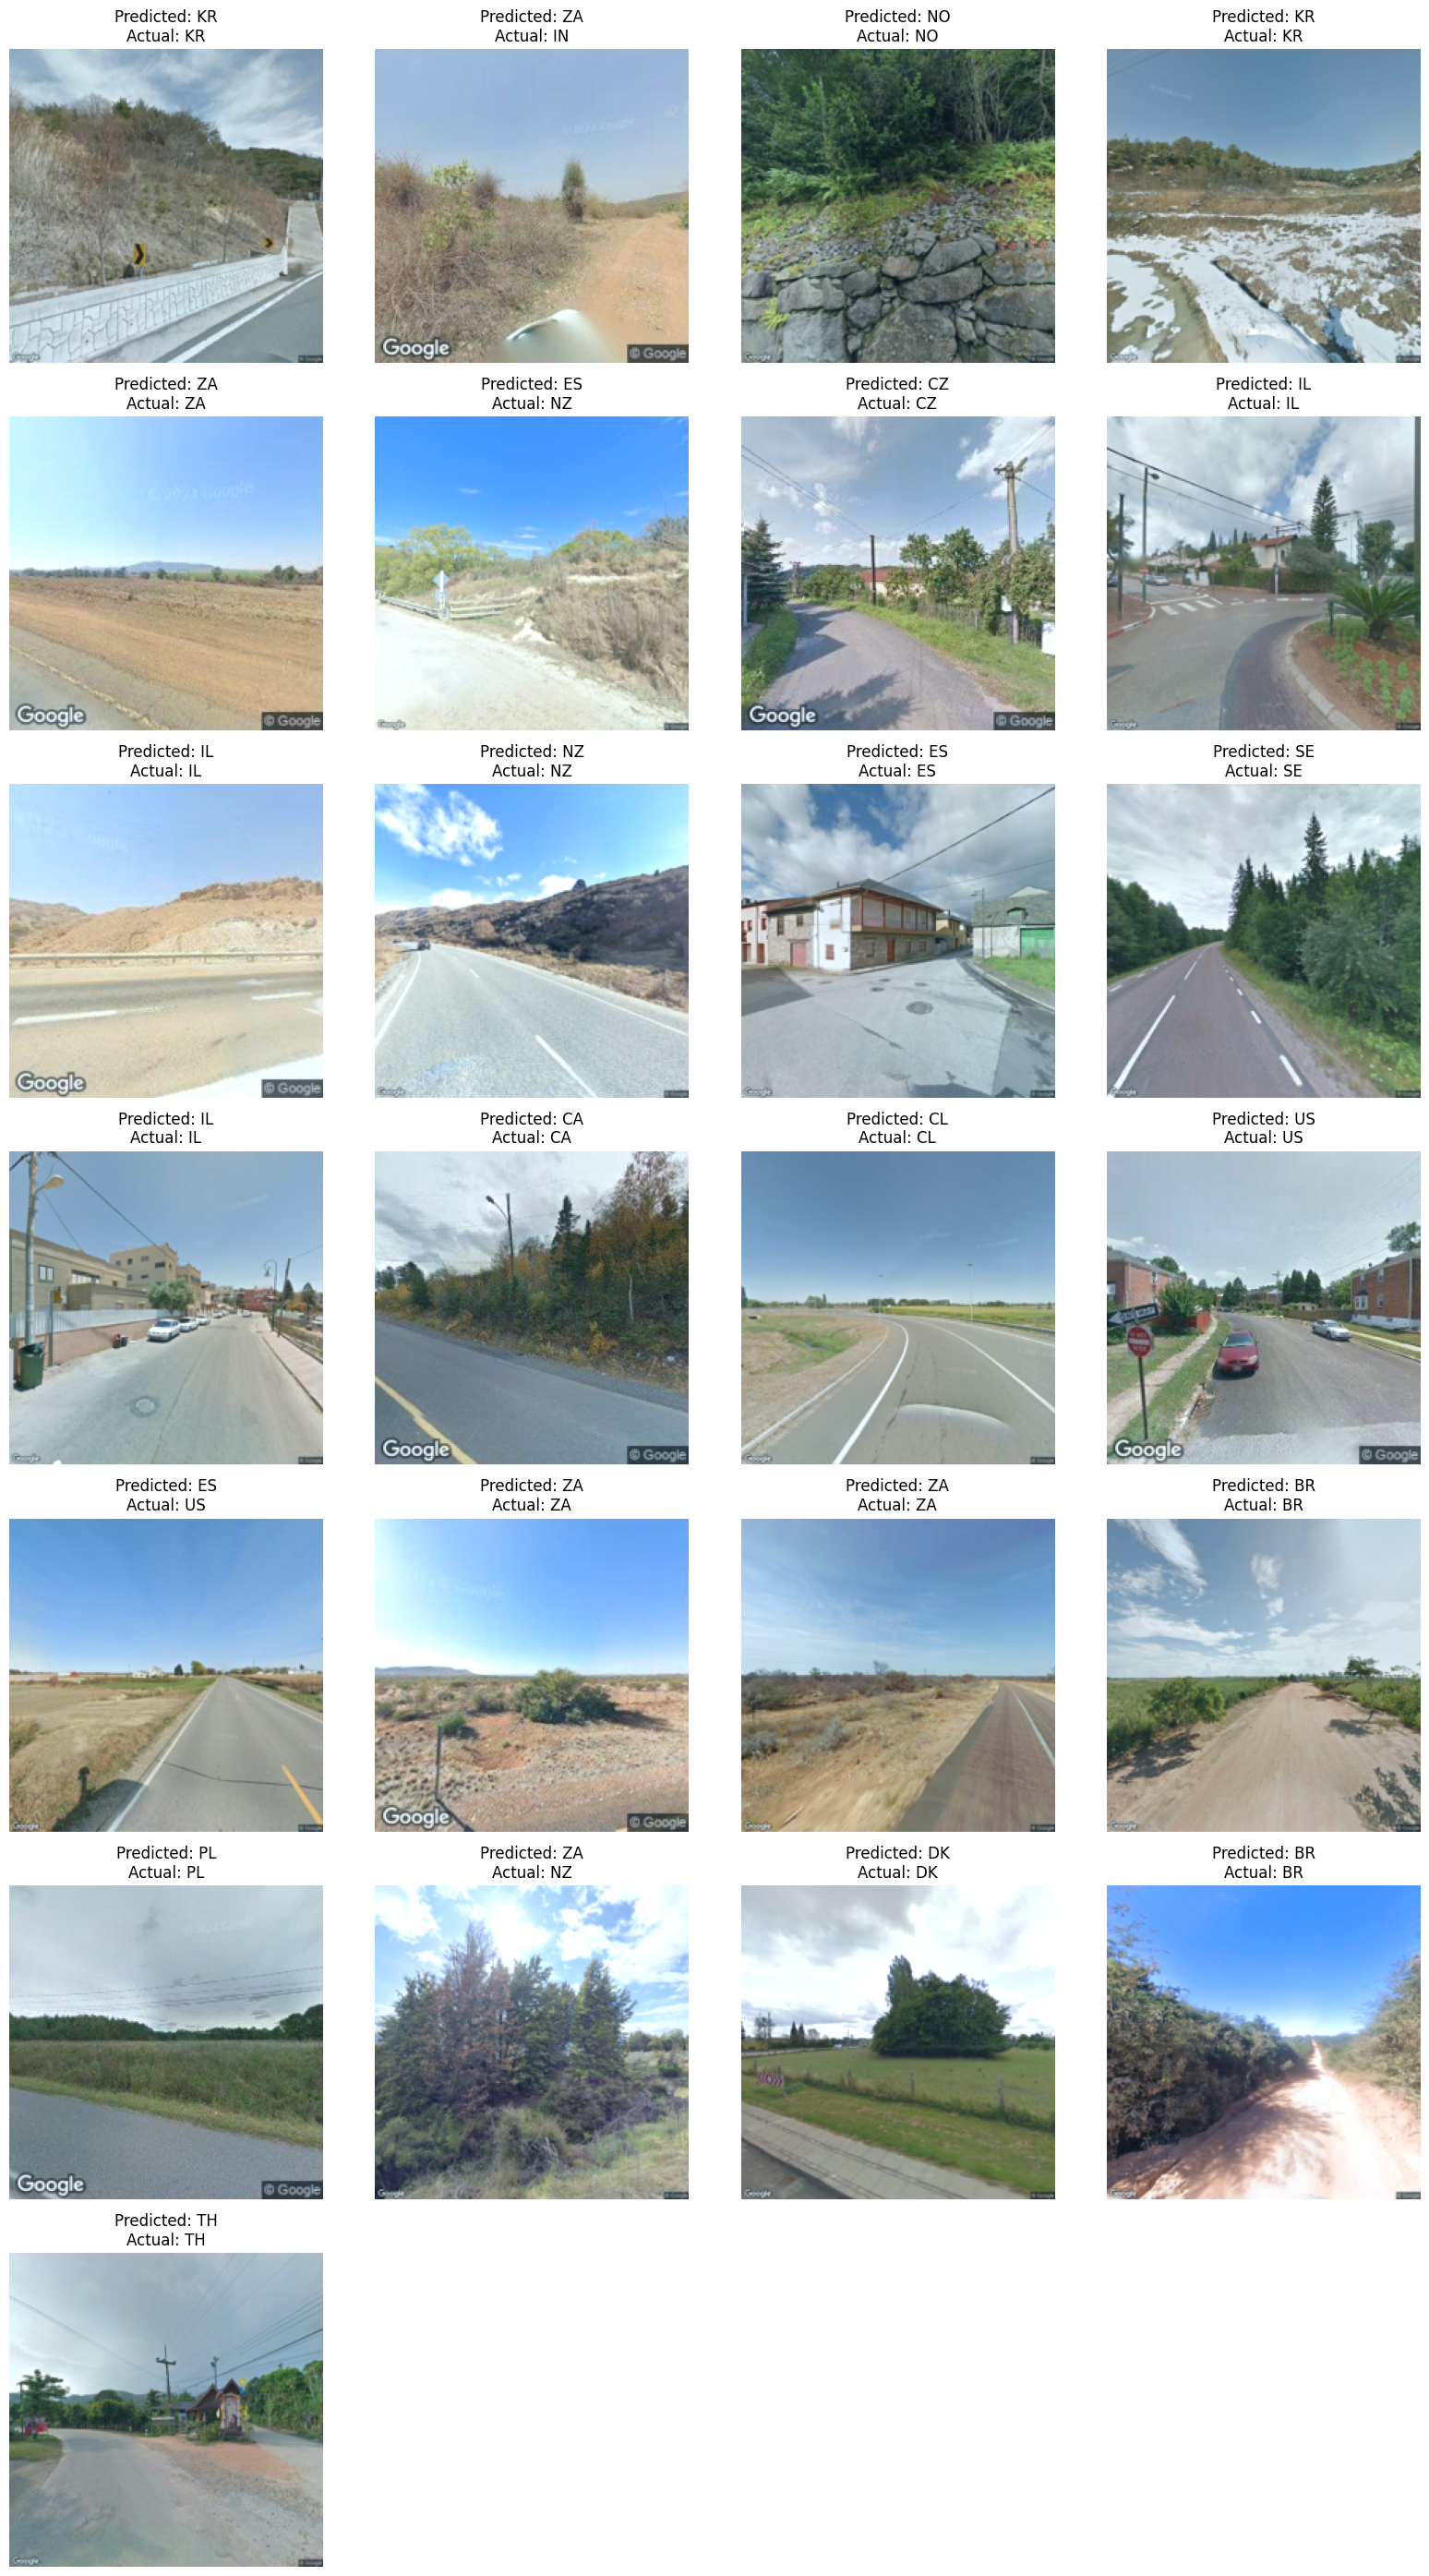

In [14]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#Here we found it interesting to display some of the pictures with their actual and predicted label, this could help us understand more
#the difficulties and simpler features that the model could deal with by looking at the picture (Used LLM).
def visualize_predictions(model, test_loader, num_images=5):
    import math  
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    class_names = full_dataset.classes
    images_shown = 0

    
    ncols = min(num_images, 4)  
    nrows = math.ceil(num_images / ncols)  

    plt.figure(figsize=(ncols * 4, nrows * 4))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown == num_images:
                    plt.tight_layout()
                    plt.show()
                    return
                image = images[i].cpu().numpy().transpose((1, 2, 0))
                # Un-normalize the image
                image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.522, 0.541, 0.521])
                image = np.clip(image, 0, 1)

                images_shown += 1
                plt.subplot(nrows, ncols, images_shown)
                plt.imshow(image)
                plt.title(f'Predicted: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}')
                plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, num_images=25)